# Klasifikasi Audio dengan PyTorch

Proyek ini akan memandu Anda untuk membuat model klasifikasi audio menggunakan PyTorch. Kita akan mengklasifikasikan suara-suara urban seperti klakson mobil (car_horn), sirene (siren), gonggongan anjing (dog), dan detak jam (clock_tick).

## Dataset
Kita akan menggunakan subset dari **ESC-50 (Environmental Sound Classification)** yang berisi rekaman suara lingkungan non-sintetis dan dapat diunduh langsung melalui notebook.

## Langkah 1: Instalasi Library yang Diperlukan

Pertama, kita perlu menginstal library-library yang akan digunakan:
- `torch` & `torchaudio`: Framework deep learning dan pemrosesan audio
- `librosa`: Library untuk analisis audio
- `soundfile`: Untuk membaca file audio
- `matplotlib`: Untuk visualisasi
- `scikit-learn`: Untuk evaluasi model
- `gdown`: Untuk mendownload dataset dari Google Drive

In [ ]:
# Install library yang diperlukan
!pip install torch torchaudio librosa soundfile matplotlib scikit-learn gdown numpy pandas

## Langkah 2: Import Library

Setelah instalasi selesai, kita import semua library yang akan digunakan.

In [2]:
# Import library yang diperlukan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import gdown
import zipfile
import shutil
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Cek apakah GPU tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else device)
print(f'Menggunakan device: {device}')

Menggunakan device: mps


## Langkah 3: Download dan Persiapan Dataset

Kita akan menggunakan subset dari **ESC-50 dataset**. Dataset ini berisi 2000 rekaman suara lingkungan dalam 50 kategori.

Untuk tutorial ini, kita akan fokus pada 4 kelas:
1. **car_horn** (klakson mobil)
2. **dog** (gonggongan anjing)
3. **siren** (sirene)
4. **clock_tick** (detak jam)

Dataset akan didownload langsung dari GitHub.

In [3]:
# Download ESC-50 Dataset (Environmental Sound Classification)
# Dataset ini berisi 2000 rekaman suara lingkungan dalam 50 kategori
# Kita akan memilih 4 kategori: dog, siren, car_horn, dan clock_tick

import os, sys, zipfile
from urllib.request import urlretrieve

zip_path = 'esc50.zip'
extract_dir = '.'
repo_zip_url = 'https://github.com/karoldvl/ESC-50/archive/master.zip'

if not os.path.exists('ESC-50-master'):
    print("Mendownload ESC-50 Dataset (±600MB terkompresi kecil, cepat)...")
    try:
        urlretrieve(repo_zip_url, zip_path)
    except Exception as e:
        print("Gagal mendownload via urlretrieve. Coba alternatif curl...")
        exit_code = os.system(f"curl -L '{repo_zip_url}' -o {zip_path}")
        if exit_code != 0:
            raise RuntimeError("Unduhan gagal. Periksa koneksi internet dan coba lagi.")
    
    print("Mengekstrak dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Dataset berhasil didownload dan diekstrak!")
else:
    print("Folder ESC-50-master sudah ada. Lewati download.")

# Path ke dataset
dataset_path = 'ESC-50-master/audio'
metadata_path = 'ESC-50-master/meta/esc50.csv'

# Baca metadata
df = pd.read_csv(metadata_path)
print(f"\nTotal file audio: {len(df)}")
print(f"Kategori yang tersedia: {df['category'].nunique()} kategori")
print("Contoh kategori:", ', '.join(sorted(df['category'].unique()[:10])))

Mendownload ESC-50 Dataset (±600MB terkompresi kecil, cepat)...
Mengekstrak dataset...
Mengekstrak dataset...
Dataset berhasil didownload dan diekstrak!

Total file audio: 2000
Kategori yang tersedia: 50 kategori
Contoh kategori: can_opening, chainsaw, chirping_birds, clapping, crow, dog, door_wood_knock, fireworks, thunderstorm, vacuum_cleaner
Dataset berhasil didownload dan diekstrak!

Total file audio: 2000
Kategori yang tersedia: 50 kategori
Contoh kategori: can_opening, chainsaw, chirping_birds, clapping, crow, dog, door_wood_knock, fireworks, thunderstorm, vacuum_cleaner


## Langkah 4: Pilih Kategori dan Persiapkan Data

Dari 50 kategori yang ada, kita akan memilih 4 kategori yang menarik untuk klasifikasi:

In [4]:
# Pilih 4 kategori untuk klasifikasi
selected_categories = ['dog', 'siren', 'car_horn', 'clock_tick']

# Filter dataset hanya untuk kategori yang dipilih
df_filtered = df[df['category'].isin(selected_categories)].copy()

print(f"Total data setelah filter: {len(df_filtered)} file audio")
print(f"\nDistribusi per kategori:")
print(df_filtered['category'].value_counts())

# Buat mapping kategori ke angka (label encoding)
category_to_id = {cat: i for i, cat in enumerate(selected_categories)}
id_to_category = {i: cat for cat, i in category_to_id.items()}

df_filtered['label'] = df_filtered['category'].map(category_to_id)

print(f"\nMapping kategori:")
for cat, idx in category_to_id.items():
    print(f"  {cat}: {idx}")

Total data setelah filter: 160 file audio

Distribusi per kategori:
category
dog           40
car_horn      40
clock_tick    40
siren         40
Name: count, dtype: int64

Mapping kategori:
  dog: 0
  siren: 1
  car_horn: 2
  clock_tick: 3


## Langkah 5: Visualisasi Contoh Audio

Mari kita lihat dan dengarkan beberapa contoh audio dari setiap kategori.

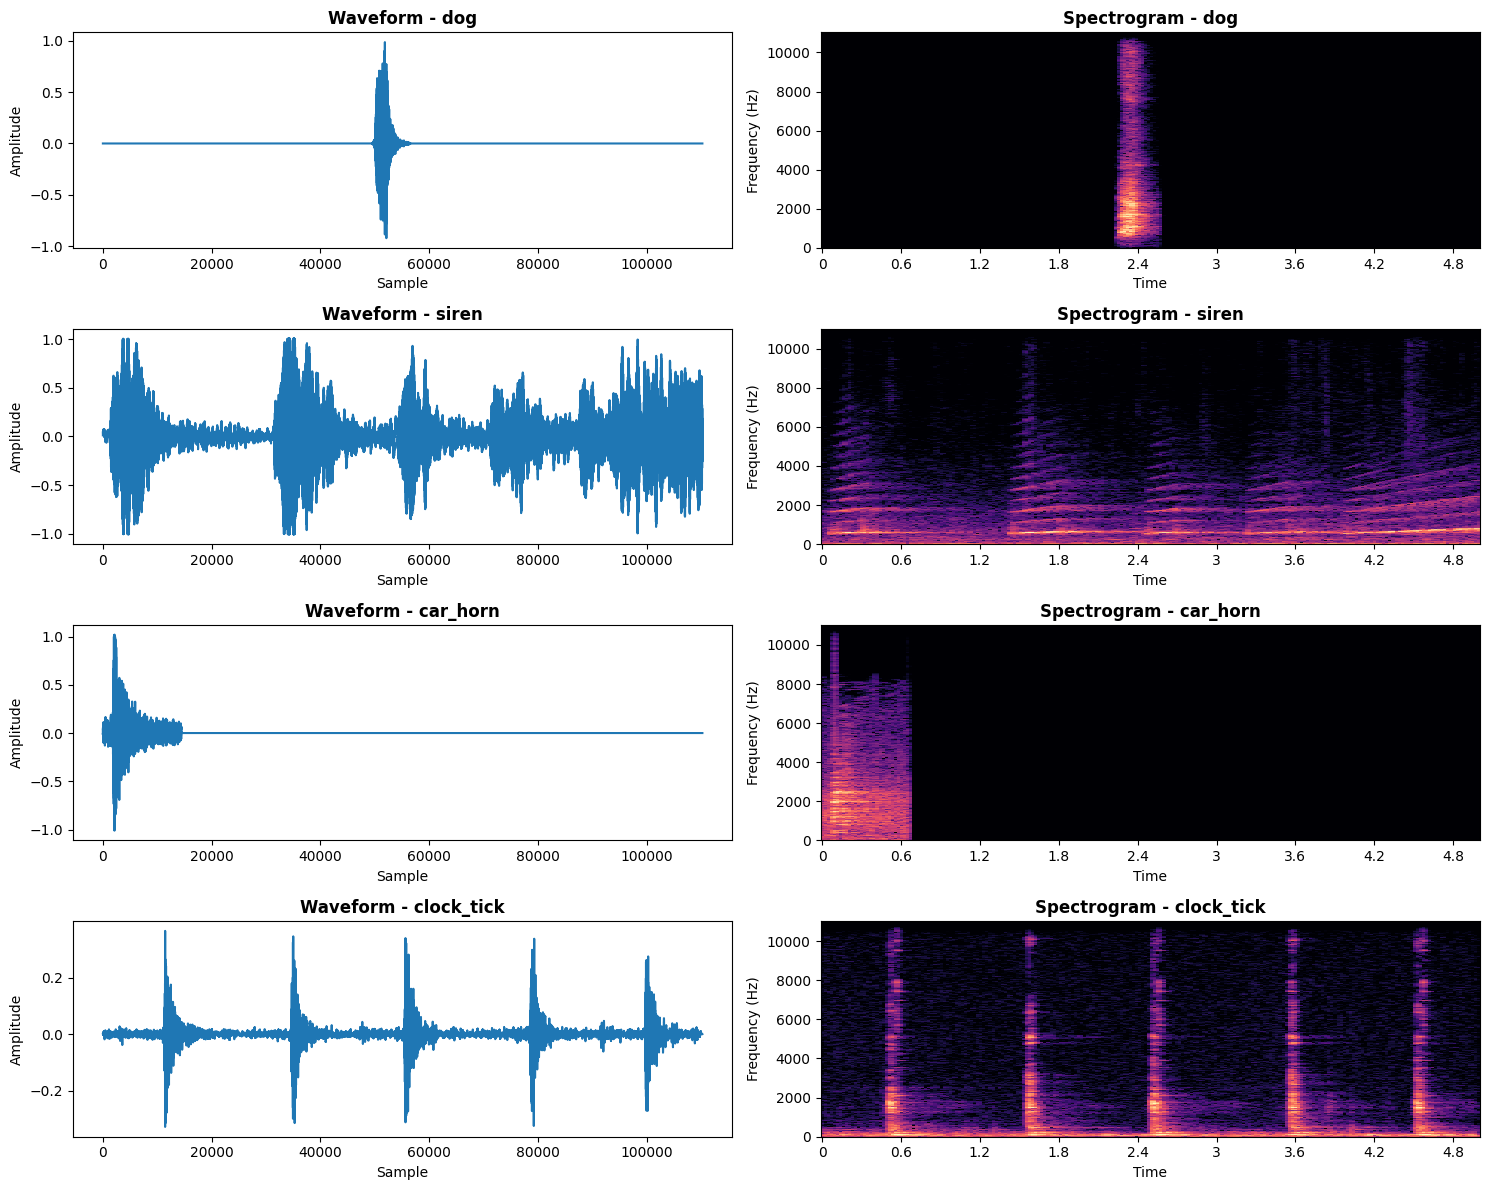


📊 Penjelasan:
- Waveform: Menampilkan amplitudo audio terhadap waktu
- Spectrogram: Menampilkan frekuensi audio terhadap waktu (lebih informatif untuk klasifikasi)


In [5]:
# Visualisasi waveform dan spectrogram untuk setiap kategori
fig, axes = plt.subplots(4, 2, figsize=(15, 12))

for idx, category in enumerate(selected_categories):
    # Ambil satu contoh dari kategori ini
    sample = df_filtered[df_filtered['category'] == category].iloc[0]
    audio_path = os.path.join(dataset_path, sample['filename'])
    
    # Load audio
    y, sr = librosa.load(audio_path, sr=22050)
    
    # Plot waveform
    axes[idx, 0].plot(y)
    axes[idx, 0].set_title(f'Waveform - {category}', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Sample')
    axes[idx, 0].set_ylabel('Amplitude')
    
    # Plot spectrogram (representasi visual dari frekuensi audio)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Spectrogram - {category}', fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Time')
    axes[idx, 1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

print("\n📊 Penjelasan:")
print("- Waveform: Menampilkan amplitudo audio terhadap waktu")
print("- Spectrogram: Menampilkan frekuensi audio terhadap waktu (lebih informatif untuk klasifikasi)")

## Langkah 6: Ekstraksi Fitur Audio (Mel-Spectrogram)

Sebelum memasukkan audio ke model neural network, kita perlu mengubah audio menjadi representasi numerik yang dapat dipelajari oleh model. Kita akan menggunakan **Mel-Spectrogram**.

**Mel-Spectrogram** adalah representasi visual dari spektrum frekuensi audio yang disesuaikan dengan cara telinga manusia mendengar suara.

In [6]:
# Fungsi untuk mengekstrak Mel-Spectrogram dari file audio
def extract_melspectrogram(audio_path, sr=22050, n_mels=64, max_length=100):
    """
    Ekstraksi Mel-Spectrogram dari file audio
    
    Parameters:
    - audio_path: path ke file audio
    - sr: sampling rate (22050 Hz adalah standar)
    - n_mels: jumlah mel bands (64 adalah ukuran yang baik untuk klasifikasi)
    - max_length: panjang maksimal dalam time steps
    
    Returns:
    - mel_spectrogram: array 2D berukuran (n_mels, max_length)
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Ekstrak Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    
    # Konversi ke skala decibel (logaritmik)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Normalisasi panjang (padding atau truncate)
    if mel_spec_db.shape[1] < max_length:
        # Padding jika terlalu pendek
        pad_width = max_length - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        # Truncate jika terlalu panjang
        mel_spec_db = mel_spec_db[:, :max_length]
    
    return mel_spec_db

# Test fungsi dengan satu contoh
sample_path = os.path.join(dataset_path, df_filtered.iloc[0]['filename'])
mel_spec = extract_melspectrogram(sample_path)
print(f"Shape Mel-Spectrogram: {mel_spec.shape}")
print(f"Dimensi: {mel_spec.shape[0]} mel bands × {mel_spec.shape[1]} time steps")

Shape Mel-Spectrogram: (64, 100)
Dimensi: 64 mel bands × 100 time steps


## Langkah 7: Buat Dataset Class untuk PyTorch

Kita perlu membuat custom Dataset class untuk memuat dan memproses data audio kita.

In [7]:
class AudioDataset(Dataset):
    """
    Custom Dataset untuk klasifikasi audio
    """
    def __init__(self, dataframe, audio_dir, sr=22050, n_mels=64, max_length=100):
        """
        Parameters:
        - dataframe: pandas DataFrame yang berisi metadata
        - audio_dir: direktori tempat file audio berada
        - sr: sampling rate
        - n_mels: jumlah mel bands
        - max_length: panjang maksimal dalam time steps
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.audio_dir = audio_dir
        self.sr = sr
        self.n_mels = n_mels
        self.max_length = max_length
    
    def __len__(self):
        """Mengembalikan jumlah total sampel"""
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        """
        Mengambil satu sampel data
        
        Returns:
        - mel_spec: Mel-Spectrogram sebagai tensor
        - label: label kategori sebagai integer
        """
        # Ambil informasi file
        row = self.dataframe.iloc[idx]
        audio_path = os.path.join(self.audio_dir, row['filename'])
        label = row['label']
        
        # Ekstrak Mel-Spectrogram
        mel_spec = extract_melspectrogram(
            audio_path, 
            sr=self.sr, 
            n_mels=self.n_mels, 
            max_length=self.max_length
        )
        
        # Konversi ke tensor PyTorch
        # Tambahkan dimensi channel (seperti grayscale image)
        mel_spec = torch.FloatTensor(mel_spec).unsqueeze(0)  # Shape: (1, n_mels, max_length)
        label = torch.LongTensor([label])[0]
        
        return mel_spec, label

print("✅ Dataset class berhasil dibuat!")

✅ Dataset class berhasil dibuat!


## Langkah 8: Split Data (Training dan Testing)

Kita akan membagi data menjadi:
- **Training set (80%)**: Untuk melatih model
- **Testing set (20%)**: Untuk mengevaluasi performa model

In [8]:
# Split data menjadi training dan testing (80:20)
train_df, test_df = train_test_split(
    df_filtered, 
    test_size=0.2, 
    random_state=42,
    stratify=df_filtered['label']  # Pastikan distribusi kelas seimbang
)

print(f"Training set: {len(train_df)} sampel")
print(f"Testing set: {len(test_df)} sampel")

print(f"\nDistribusi kelas di Training set:")
print(train_df['category'].value_counts())

print(f"\nDistribusi kelas di Testing set:")
print(test_df['category'].value_counts())

# Buat Dataset objects
train_dataset = AudioDataset(train_df, dataset_path)
test_dataset = AudioDataset(test_df, dataset_path)

# Buat DataLoader untuk batch processing
batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Acak data saat training
    num_workers=0  # Set 0 untuk menghindari error di beberapa sistem
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=0
)

print(f"\n✅ DataLoader berhasil dibuat!")
print(f"Jumlah batch training: {len(train_loader)}")
print(f"Jumlah batch testing: {len(test_loader)}")

Training set: 128 sampel
Testing set: 32 sampel

Distribusi kelas di Training set:
category
siren         32
dog           32
car_horn      32
clock_tick    32
Name: count, dtype: int64

Distribusi kelas di Testing set:
category
clock_tick    8
car_horn      8
siren         8
dog           8
Name: count, dtype: int64

✅ DataLoader berhasil dibuat!
Jumlah batch training: 8
Jumlah batch testing: 2


## Langkah 9: Definisi Model CNN (Convolutional Neural Network)

Kita akan membuat model CNN sederhana yang terdiri dari:
1. **Convolutional layers**: Untuk ekstraksi fitur dari Mel-Spectrogram
2. **Pooling layers**: Untuk mengurangi dimensi dan menghindari overfitting
3. **Fully connected layers**: Untuk klasifikasi akhir

Model ini cukup sederhana dan bisa dilatih di Google Colab.

In [9]:
class AudioCNN(nn.Module):
    """
    Model CNN sederhana untuk klasifikasi audio
    """
    def __init__(self, num_classes=4):
        super(AudioCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(
            in_channels=1,      # Input: 1 channel (grayscale mel-spectrogram)
            out_channels=16,    # Output: 16 feature maps
            kernel_size=3,      # Filter size 3x3
            padding=1           # Padding agar ukuran sama
        )
        self.bn1 = nn.BatchNorm2d(16)  # Normalisasi untuk stabilitas training
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Mengurangi ukuran menjadi setengah
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        # Input size setelah 3 pooling: 64 channels × (64/8) × (100/8) = 64 × 8 × 12
        self.fc1 = nn.Linear(64 * 8 * 12, 128)
        self.dropout = nn.Dropout(0.5)  # Dropout untuk menghindari overfitting
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        Forward pass
        x shape: (batch_size, 1, 64, 100)
        """
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)  # Shape: (batch, 16, 32, 50)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)  # Shape: (batch, 32, 16, 25)
        
        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)  # Shape: (batch, 64, 8, 12)
        
        # Flatten untuk fully connected layer
        x = x.view(x.size(0), -1)  # Shape: (batch, 64*8*12)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # Output: (batch, num_classes)
        
        return x

# Inisialisasi model
model = AudioCNN(num_classes=len(selected_categories))
model = model.to(device)

# Hitung jumlah parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Model berhasil dibuat!")
print(f"\nTotal parameter: {total_params:,}")
print(f"Trainable parameter: {trainable_params:,}")
print(f"\nArsitektur model:")
print(model)

✅ Model berhasil dibuat!

Total parameter: 810,596
Trainable parameter: 810,596

Arsitektur model:
AudioCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6144, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=12

## Langkah 10: Setup Training

Sebelum melatih model, kita perlu menentukan:
1. **Loss function**: Untuk mengukur seberapa jauh prediksi dari target
2. **Optimizer**: Untuk mengupdate weight model
3. **Learning rate**: Kecepatan pembelajaran model

In [11]:
# Loss function: CrossEntropyLoss untuk multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam (adaptive learning rate)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler: Mengurangi learning rate jika tidak ada improvement
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5,     # Kurangi LR menjadi setengah
    patience=3,     # Tunggu 3 epoch sebelum mengurangi LR
    # verbose=True
)

print("✅ Training setup selesai!")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam")
print(f"Learning rate: {learning_rate}")

✅ Training setup selesai!
Loss function: CrossEntropyLoss
Optimizer: Adam
Learning rate: 0.001


## Langkah 11: Fungsi Training dan Evaluasi

Kita akan membuat fungsi untuk:
1. Melatih model pada training set
2. Mengevaluasi model pada testing set

In [13]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Melatih model untuk satu epoch
    """
    model.train()  # Set model ke mode training
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar
    pbar = tqdm(dataloader, desc='Training')
    
    for inputs, labels in pbar:
        # Pindahkan data ke device (GPU/CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero gradient
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass dan optimisasi
        loss.backward()
        optimizer.step()
        
        # Statistik
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """
    Evaluasi model pada testing set
    """
    model.eval()  # Set model ke mode evaluasi
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Tidak perlu gradient untuk evaluasi
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistik
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Simpan prediksi untuk confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

print("✅ Fungsi training dan evaluasi berhasil dibuat!")

✅ Fungsi training dan evaluasi berhasil dibuat!


## Langkah 12: Jalankan Proses Training

Kita akan melatih model selama beberapa epoch dan memantau metrik **loss** dan **accuracy** pada training dan testing set.


===== Epoch 1/10 =====


Training: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s, loss=1.4910, acc=38.28%]



Train  | Loss: 2.3078 | Acc: 38.28%
Test   | Loss: 1.7843 | Acc: 31.25%
⭐️ Model terbaik diperbarui (Test Acc: 31.25%)

===== Epoch 2/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 12.75it/s, loss=1.1237, acc=53.12%]



Train  | Loss: 1.5270 | Acc: 53.12%
Test   | Loss: 0.7735 | Acc: 65.62%
⭐️ Model terbaik diperbarui (Test Acc: 65.62%)

===== Epoch 3/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 12.04it/s, loss=0.6263, acc=69.53%]



Train  | Loss: 0.7361 | Acc: 69.53%
Test   | Loss: 0.6447 | Acc: 81.25%
⭐️ Model terbaik diperbarui (Test Acc: 81.25%)

===== Epoch 4/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 12.57it/s, loss=0.4419, acc=81.25%]



Train  | Loss: 0.5799 | Acc: 81.25%
Test   | Loss: 0.5569 | Acc: 78.12%

===== Epoch 5/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 12.42it/s, loss=0.3090, acc=83.59%]



Train  | Loss: 0.4797 | Acc: 83.59%
Test   | Loss: 0.5583 | Acc: 75.00%

===== Epoch 6/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 12.38it/s, loss=0.3107, acc=88.28%]



Train  | Loss: 0.2929 | Acc: 88.28%
Test   | Loss: 0.4549 | Acc: 81.25%

===== Epoch 7/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 12.54it/s, loss=0.1997, acc=88.28%]



Train  | Loss: 0.3570 | Acc: 88.28%
Test   | Loss: 0.7380 | Acc: 75.00%

===== Epoch 8/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 12.34it/s, loss=0.1621, acc=91.41%]



Train  | Loss: 0.2026 | Acc: 91.41%
Test   | Loss: 0.6267 | Acc: 84.38%
⭐️ Model terbaik diperbarui (Test Acc: 84.38%)

===== Epoch 9/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 11.49it/s, loss=0.4700, acc=91.41%] 



Train  | Loss: 0.2377 | Acc: 91.41%
Test   | Loss: 0.5860 | Acc: 84.38%

===== Epoch 10/10 =====


Training: 100%|██████████| 8/8 [00:00<00:00, 13.24it/s, loss=0.1387, acc=92.97%]



Train  | Loss: 0.1740 | Acc: 92.97%
Test   | Loss: 0.7248 | Acc: 81.25%


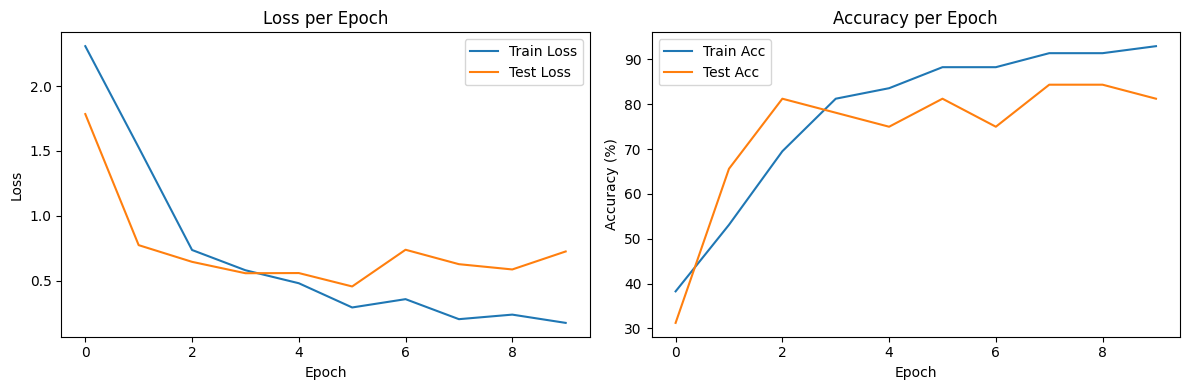


✅ Training selesai. Akurasi test terbaik: 84.38%


In [14]:
num_epochs = 10  # Anda bisa naikkan jika menggunakan GPU

history = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': []
}

best_test_acc = 0.0
best_state = None

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    # Scheduler step (berdasarkan validation/test loss)
    scheduler.step(test_loss)
    
    # Simpan riwayat
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
    print(f"Train  | Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"Test   | Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")
    
    # Simpan model terbaik berdasarkan akurasi test
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_state = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'test_acc': test_acc,
        }
        print(f"⭐️ Model terbaik diperbarui (Test Acc: {test_acc:.2f}%)")

# Plot kurva training
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history['train_loss'], label='Train Loss')
axs[0].plot(history['test_loss'], label='Test Loss')
axs[0].set_title('Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history['train_acc'], label='Train Acc')
axs[1].plot(history['test_acc'], label='Test Acc')
axs[1].set_title('Accuracy per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

plt.tight_layout()
plt.show()

print(f"\n✅ Training selesai. Akurasi test terbaik: {best_test_acc:.2f}%")

## Langkah 13: Evaluasi Akhir (Classification Report & Confusion Matrix)

Kita akan melihat detail performa model per kelas menggunakan **classification report** dan **confusion matrix**.

Memuat model terbaik dari epoch 8 (Test Acc: 84.38%)

Final Test Loss: 0.7248 | Final Test Acc: 81.25%

Classification Report:
              precision    recall  f1-score   support

         dog       0.80      1.00      0.89         8
       siren       0.83      0.62      0.71         8
    car_horn       0.70      0.88      0.78         8
  clock_tick       1.00      0.75      0.86         8

    accuracy                           0.81        32
   macro avg       0.83      0.81      0.81        32
weighted avg       0.83      0.81      0.81        32



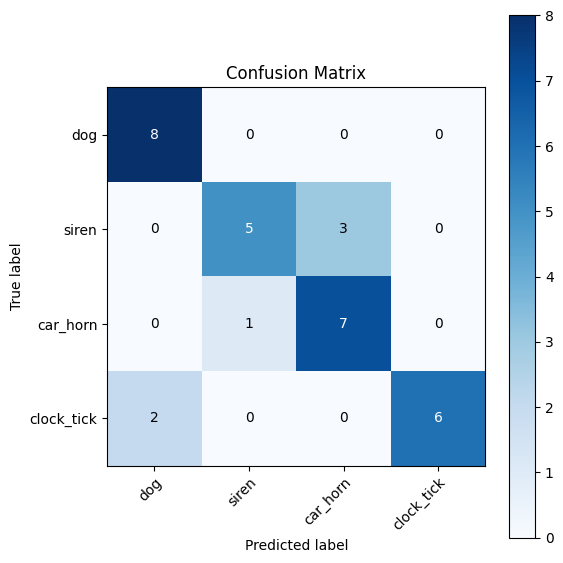

In [15]:
# Gunakan model terbaik jika tersedia
if best_state is not None:
    model.load_state_dict(best_state['model_state_dict'])
    print(f"Memuat model terbaik dari epoch {best_state['epoch']} (Test Acc: {best_state['test_acc']:.2f}%)")

# Evaluasi dan dapatkan prediksi
test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=[id_to_category[i] for i in range(len(selected_categories))]))

# Confusion matrix
cm = confusion_matrix(labels, preds)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=[id_to_category[i] for i in range(len(selected_categories))],
       yticklabels=[id_to_category[i] for i in range(len(selected_categories))],
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion Matrix')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Annotasi angka pada setiap sel
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## Langkah 14: Demo Inferensi pada Satu Audio

Kita akan memilih satu file audio dari testing set, menampilkan Mel-Spectrogram, lalu memprediksi kategorinya.

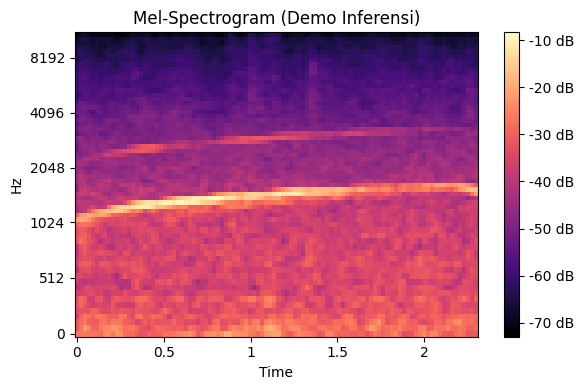

File: 5-160551-A-42.wav
Label Asli: siren
Prediksi  : car_horn

Probabilitas per kelas:
  dog         :  0.59%
  siren       :  4.76%
  car_horn    : 93.76%
  clock_tick  :  0.89%


In [18]:
import random

# Pilih satu sampel dari test set
sample_row = test_df.sample(1, random_state=random.randint(0, 9999)).iloc[0]
sample_path = os.path.join(dataset_path, sample_row['filename'])
true_label = sample_row['label']
true_category = id_to_category[true_label]

# Ekstraksi fitur
mel_spec = extract_melspectrogram(sample_path)
mel_tensor = torch.FloatTensor(mel_spec).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, 64, 100)

# Prediksi
model.eval()
with torch.no_grad():
    logits = model(mel_tensor)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    pred_category = id_to_category[pred_id]

# Visualisasi Mel-Spectrogram
plt.figure(figsize=(6, 4))
librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', sr=22050)
plt.title('Mel-Spectrogram (Demo Inferensi)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(f"File: {sample_row['filename']}")
print(f"Label Asli: {true_category}")
print(f"Prediksi  : {pred_category}")

# Tampilkan probabilitas per kelas
print("\nProbabilitas per kelas:")
for i, p in enumerate(probs):
    print(f"  {id_to_category[i]:<12}: {p*100:5.2f}%")

## Langkah 15: Simpan dan Muat Ulang Model

Menyimpan model memudahkan kita melakukan inferensi di lain waktu tanpa perlu training ulang.

In [19]:
import json

# Simpan model terbaik jika ada
save_path = 'audio_cnn_best.pth'
classes_path = 'classes.json'

if best_state is not None:
    torch.save(best_state, save_path)
    print(f"Model terbaik disimpan ke: {save_path}")
else:
    # Jika tidak ada best_state (misal hanya 1 epoch), simpan state saat ini
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': num_epochs,
        'test_acc': test_acc if 'test_acc' in locals() else None,
    }, save_path)
    print(f"Model saat ini disimpan ke: {save_path}")

# Simpan mapping kelas
with open(classes_path, 'w') as f:
    json.dump(id_to_category, f)
print(f"Mapping kelas disimpan ke: {classes_path}")

# Contoh memuat ulang model
def load_model(model_path, classes_path, num_classes):
    model = AudioCNN(num_classes=num_classes)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state['model_state_dict'])
    model.to(device)
    with open(classes_path, 'r') as f:
        id_to_category = json.load(f)
        # keys JSON adalah string, ubah ke int
        id_to_category = {int(k): v for k, v in id_to_category.items()}
    return model, id_to_category

# Uji fungsi load
_loaded_model, _loaded_map = load_model(save_path, classes_path, len(selected_categories))
_loaded_model.eval()
print("\n✅ Model berhasil dimuat ulang untuk inferensi.")

Model terbaik disimpan ke: audio_cnn_best.pth
Mapping kelas disimpan ke: classes.json

✅ Model berhasil dimuat ulang untuk inferensi.


## Tips Menjalankan di Google Colab

- Aktifkan GPU: `Runtime > Change runtime type > Hardware accelerator: GPU`.
- Waktu training: 10 epoch biasanya selesai dalam beberapa menit.
- Anda bisa menambah `num_epochs` untuk akurasi lebih baik saat menggunakan GPU.